Programming assignment 3: Stance classification

Part 3: Implementing your stance classification system

In [1]:
# import needed libraries for all the tasks
import pandas as pd 
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from cleantext import clean
from string import digits
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm  import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
#load training data
data_train = pd.read_csv("./a3_train_final.tsv", names = ["Annotations", "comments"], sep = "\t")

#check training data
print("Length of Train data is ", len(data_train))
data_train.head(20)


Length of Train data is  37885


,Annotations,comments
0,1/1,I'll only consume if I know what's inside it....
1,0/-1,It is easier to fool a million people than it...
2,0/0,NATURAL IMMUNITY protected us since evolutio...
3,0/-1,NATURAL IMMUNITY protected us since evolutio...
4,1/1/1/-1,The bigest sideffect of vaccines is fewer dea...
5,1/-1,Unvaccinated people are more likely to become...
6,1/1,Vaccine takes more than a year to develop. T...
7,0/0,YES IM A TRUCKER FROM USA AND I WONT GET VACC...
8,1/-1,just because I don't have dr in front of my n...
9,1/1,out of anger People say stupid things man is ...


In [7]:
#load test data
data_test = pd.read_csv("./a3_test.tsv", names = ["Annotations", "comments"], sep = "\t")

#check the test data
print("Length of test data is ", len(data_test))
data_test.head(10)

Length of test data is  1524


,Annotations,comments
0,1,I did my own research means you looked online ...
1,1,I don't know what's in it. As if they know wha...
2,1,"In the September time frame, unvaccinated peop..."
3,0,It is a pity that people are dying from the va...
4,0,No long-term safety data? No problem! - Every ...
5,0,The protein Spike is in itself harmless they m...
6,0,We take other risks so taking this one shouldn...
7,0,anti-vaccer is a weaponized term so these phar...
8,0,"if you don't have the vaccine, you're robbing ..."
9,0,#Poison


Function for Cleaning comments

In [8]:
def CleanData(comments):

    #change all comments to lowercase
    comments=comments.lower()

    #remove contractions
    comments = re.sub(r"n\'t", " not", comments)
    comments = re.sub(r"\'re", " are", comments)
    comments = re.sub(r"\'s", " is", comments)
    comments = re.sub(r"\'d", " would", comments)
    comments = re.sub(r"\'ll", " will", comments)
    comments = re.sub(r"\'ve", " have", comments)
    comments = re.sub(r"\'m", " am", comments)

    #remove extra spaces
    comments = re.sub(r"\s+", " ", comments)

    #remove emoji
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    comments = re.sub(emoj, '', comments)

    #remove extra and unneeded punctuations and signs
    comments = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?" , " " , comments)

    #remove numbers
    num_table = str.maketrans(" ", " ", digits)
    comments = comments.translate(num_table)

    return comments


Cleaning the comments for training data

In [9]:
#clean the training data
data_train["Cleaned_comments"] = data_train["comments"].apply(lambda x: CleanData(x))

data_train["comments"] = data_train ['Cleaned_comments']
#data_train.drop(columns= ["Cleaned_comments"])
del data_train['Cleaned_comments']
data_train

,Annotations,comments
0,1/1,i will only consume if i know what is inside ...
1,0/-1,it is easier to fool a million people than it...
2,0/0,natural immunity protected us since evolution...
3,0/-1,natural immunity protected us since evolution...
4,1/1/1/-1,the bigest sideffect of vaccines is fewer dea...
...,...,...
37880,0/0,keep your i already know people who have be...
37881,0/0,just because it is safe does not mean it do...
37882,0/0,i took the vaccine because of work if i do n...
37883,0/0,there is people already having severe side eff...


Cleaning the comments for test data

In [10]:
#clean the comments for test data
data_test["Cleaned_comments"] = data_test["comments"].apply(lambda x: CleanData(x))

data_test["comments"] = data_test ['Cleaned_comments']
del data_test['Cleaned_comments']
data_test

,Annotations,comments
0,1,i did my own research means you looked online ...
1,1,i do not know what is in it as if they know w...
2,1,in the september time frame unvaccinated peop...
3,0,it is a pity that people are dying from the va...
4,0,no long term safety data no problem every ...
...,...,...
1519,0,covid is created by demon earth is turnong ...
1520,0,medical professionals that don t even eat he...
1521,1,no vaccine has ever been proven effective t...
1522,0,we cannot have normality until everyone globa...


Function for Cleaning Annotations

In [11]:
def check_all_equal(chr_list):
    return all(x == chr_list[0] for x in chr_list)


def filter_data(data_train_df):
    row_list_dict = {"Annotations": [], "comments": []}

    for index, row in data_train_df.iterrows():
        ann_list = row['Annotations'].split('/')
        all_equal_ = check_all_equal(ann_list)
        if all_equal_:
            rows_dict = row.to_dict()
            row_list_dict["Annotations"].append(rows_dict["Annotations"])
            row_list_dict["comments"].append(rows_dict["comments"])
            #row_list_dict["Cleaned_comments"].append(rows_dict["Cleaned_comments"])

    return pd.DataFrame.from_dict(row_list_dict)

Cleanin Annotations for training data

In [12]:
# Clean Annotations for training data 

data_train_cl = filter_data(data_train)
data_train_cl["Annotations"] = data_train_cl['Annotations'].replace(["0/0", "1/1"] , ["0", "1"])
print(data_train_cl)

      Annotations                                           comments
0               1   i will only consume if i know what is inside ...
1               0   natural immunity protected us since evolution...
2               1   vaccine takes more than a year to develop  th...
3               0   yes im a trucker from usa and i wont get vacc...
4               1   out of anger people say stupid things man is ...
...           ...                                                ...
32090           0   keep your  i already know  people who have be...
32091           0    just because it is safe  does not mean it do...
32092           0   i took the vaccine because of work  if i do n...
32093           0  there is people already having severe side eff...
32094           1  i my covid vaccines and i am so excited for my...

[32095 rows x 2 columns]


Extract Features

In [13]:

#convert text documents into a matrix of term frequency-inverse document frequency (TF-IDF) features.

vectorizer1 = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
vectorizer2 = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

data_train_vec_matrix = vectorizer1.fit_transform(data_train_cl['comments'])
data_train_vec_array = data_train_vec_matrix.toarray()

vectorizer2 = TfidfVectorizer(vocabulary=vectorizer1.vocabulary_)


data_test_vec_matrix = vectorizer2.fit_transform(data_test['comments'])
data_test_vec_array = data_test_vec_matrix.toarray()

Xtest = data_test_vec_array
data_test["Annotations"] = data_test['Annotations'].replace([0, 1] , ["0", "1"])
Ytest = data_test['Annotations']


Split the data to train and validation set

In [14]:
# Split the training data to train and validation sets

Xtrain, Xval = train_test_split(data_train_vec_array, train_size   = 0.8, random_state = 0)
Ytrain, Yval  = train_test_split (data_train_cl ['Annotations'], train_size   = 0.8, random_state = 0)

print("Number of comments:", len(data_train))
print("Number of cleaned Comments:", len(data_train_cl))
print("Size of trianing set:", len(Xtrain))
print("size of validation set:", len(Xval))

Number of comments: 37885
Number of cleaned Comments: 32095
Size of trianing set: 25676
size of validation set: 6419


Logistic Regression model with the best hyperparameters

In [15]:
LR_model = LogisticRegression(C=1, penalty="l2", random_state=0)
LR_model.fit(Xtrain,Ytrain)
guess_annot_LR = LR_model.predict(Xval)
LR_model_accuracy = accuracy_score(guess_annot_LR, Yval)
print(f"Logistic Regression_score: {LR_model_accuracy}")


Logistic Regression_score: 0.757594640909799


Finding the best hyperparameters for Logistic Regression

In [ ]:

param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
search = GridSearchCV(LogisticRegression(), param_grid)
search.fit(Xtrain, Ytrain )
print('Logistic Regression parameters: ', search.best_params_)

Linear Support Vector Machine Model 

In [56]:
LSVC_model = LinearSVC(random_state=0)
LSVC_model.fit(Xtrain,Ytrain)
guess_annot_LSVC = LSVC_model.predict(Xval)
LSVC_model_accuracy = accuracy_score(guess_annot_LSVC, Yval)
print(f"Linear SVC_score: {LSVC_model_accuracy}")

Linear SVC_score: 0.7449758529365945


Random Forest Model

In [57]:
RF_model = RandomForestClassifier(n_estimators=200, max_depth=3,  random_state=0)
RF_model.fit(Xtrain,Ytrain)
guess_annot_RF = RF_model.predict(Xval)
RF_model_accuracy = accuracy_score(guess_annot_RF, Yval)
print(f"Random For_score: {RF_model_accuracy}")

Random For_score: 0.6326530612244898


Test the model with test dataset

In [73]:
Yguess = LR_model.predict(Xtest)
print('Logistic Regression  accuracy: ' + str(accuracy_score(Ytest,Yguess)))
data_test['prediction'] = Yguess.tolist()
data_test.head(10)

Logistic Regression  accuracy: 0.8195538057742782


,Annotations,comments,prediction
0,1,i did my own research means you looked online ...,1
1,1,i do not know what is in it as if they know w...,0
2,1,in the september time frame unvaccinated peop...,1
3,0,it is a pity that people are dying from the va...,0
4,0,no long term safety data no problem every ...,0
5,0,the protein spike is in itself harmless they m...,0
6,0,we take other risks so taking this one shouldn...,1
7,0,anti vaccer is a weaponized term so these phar...,0
8,0,if you do not have the vaccine you are robbin...,0
9,0,poison,0


Printing the wrong predicted comments

In [59]:
wrong_prediction = pd.DataFrame({"comment": [], "prediction": [], "correct": []})
for index, row in data_test.iterrows():
    if row['Annotations'] != row['prediction']:
        wrong_prediction = wrong_prediction.append({
            "comment": row['comments'],
            "prediction": "Provaccine" if row['prediction']=="1" else "Antivaccine",
            "correct": "Provaccine" if row['Annotations']=="1" else "Antivaccine",
        }, ignore_index=True)
wrong_prediction.head(10)


,comment,prediction,correct
0,i do not know what is in it as if they know w...,Antivaccine,Provaccine
1,we take other risks so taking this one shouldn...,Provaccine,Antivaccine
2,against hospitalization and death they shou...,Antivaccine,Provaccine
3,years ago today i took a vaccine that i was l...,Provaccine,Antivaccine
4,of active cases have mild or no symptoms w...,Provaccine,Antivaccine
5,a big thanks to germany biontech ftw,Antivaccine,Provaccine
6,a good friend is recovering after covid havin...,Antivaccine,Provaccine
7,about months ago i had covid i just got my...,Provaccine,Antivaccine
8,about a year ago my wife is unvaxxed friend g...,Antivaccine,Provaccine
9,after every covid vaccine dose my eczema got ...,Provaccine,Antivaccine


Confusion Matrix

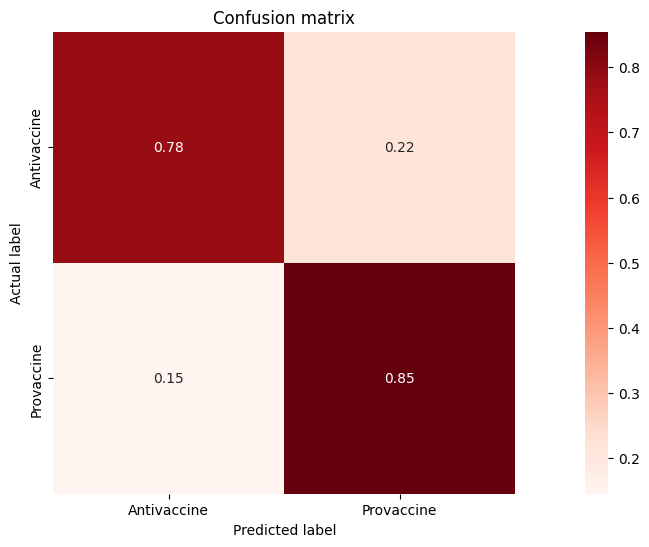

In [60]:
C_Matrix = confusion_matrix(Ytest, Yguess, normalize="true")

labels = ["Antivaccine", "Provaccine"]
plt.figure(figsize=(18, 6))
sns.heatmap(C_Matrix, annot=True, square=True, cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion matrix")
plt.show()

Finding the best features

In [61]:
coef = LR_model.coef_[0]
feature_importance = np.abs(coef)
feature_names = vectorizer1.get_feature_names_out()
sorted_idx = np.argsort(feature_importance)[::-1]
df = pd.DataFrame({'Feature Name': feature_names[sorted_idx],'Importance Score': feature_importance[sorted_idx]})
print(df)


          Feature Name  Importance Score
0          antivaxxers          2.971925
1                today          2.921158
2                 soon          2.582341
3            available          2.542273
4                 anti          2.346805
...                ...               ...
12378       medication          0.000136
12379      blood cells          0.000095
12380      unknowingly          0.000087
12381      threatening          0.000077
12382  watching people          0.000000

[12383 rows x 2 columns]
